In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from random import sample
from skimage.util import random_noise
from skimage.transform import resize
from sklearn.model_selection import train_test_split # split training and testing dataset
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio
from torch.utils.data import Dataset
import torchvision

In [2]:
# class CustomImageDataset(Dataset):
#     def __init__(self, img_dir, num_im):
#         self.img_dir = img_dir
#         self.num_im = num_im
#     def __len__(self):
#         return self.num_im

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir[idx])
#         mat = scipy.io.loadmat(img_path)
#         data = np.array(mat['im'])
#         data = resize(data,(256,256))
#         data.shape = (data.shape[0],data.shape[1],1)
#         return image

# class CustomImageDatasetN(Dataset):
#     def __init__(self, img_dir, num_im):
#         self.img_dir = img_dir
#         self.num_im = num_im
#     def __len__(self):
#         return self.num_im

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir[idx])
#         mat = scipy.io.loadmat(img_path)
#         data = np.array(mat['nim'])
#         data = resize(data,(256,256))
#         data.shape = (data.shape[0],data.shape[1],1)
#         return image

In [3]:
# data_dir = 'C:/Users/wnewm/NeuralNetworks_python/TrueTrain' # Put your own data directory here
# mat_files   = [f for f in os.listdir(data_dir) if f.endswith('.mat')]
# for idx,f in enumerate(mat_files): 
#     mat_files[idx] = data_dir+'/'+f
# my_data = CustomImageDataset(mat_files,len(mat_files))
# GT = 

In [5]:
def MatLoader(data_dir):
    mat_files   = [f for f in os.listdir(data_dir) if f.endswith('.mat')]
    mat_data    = []
    for f in mat_files:
            # ---
            st = data_dir + '/' + f
            mat = scipy.io.loadmat(st)
            data = np.array(mat['im'])
            data = resize(data,(256,256))
            data.shape = (data.shape[0],data.shape[1],1)
            mat_data.append(np.transpose(data,(2,0,1)))
            # ---
    return np.double(np.concatenate(mat_data[:],axis=0))
def MatLoaderN(data_dir):
    mat_files   = [f for f in os.listdir(data_dir) if f.endswith('.mat')]
    mat_data    = []
    for f in mat_files:
            # ---
            st = data_dir + '/' + f
            mat = scipy.io.loadmat(st)
            data = np.array(mat['nim'])
            data = resize(data,(256,256))
            data.shape = (data.shape[0],data.shape[1],1)
            mat_data.append(np.transpose(data,(2,0,1)))
            # ---
    return np.double(np.concatenate(mat_data[:],axis=0))

data_dir = 'C:/Users/wnewm/NeuralNetworks_python/TrueTrain2' # Put your own data directory here
data_dirLN = 'C:/Users/wnewm/NeuralNetworks_python/NoisyLow2'
# data_dir = 'D:/QC500/TrueTrain2'
# data_dirLN = 'D:/QC500/NoisyLow2'
GT   = MatLoader(data_dir) 
LN   = MatLoaderN(data_dirLN) 
# MN   = MatLoaderN(data_dirMN) 
# HN   = MatLoaderN(data_dirHN)
print(GT.shape)  
print(LN.shape) 
# print(MN.shape) 
# print(HN.shape)

(2001, 256, 256)
(2001, 256, 256)


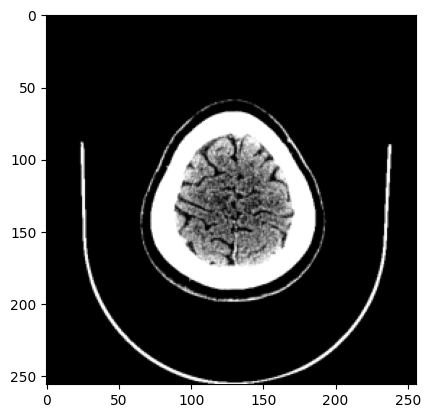

In [6]:
plt.imshow(GT[-1,:,:],cmap='gray')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(GT, LN, test_size=0.20)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
batch_size = 8

# ---
# Your codes here to convert data into torch tensor format and create a data loader
# ---
trainData = torch.utils.data.TensorDataset(torch.tensor(y_train, dtype=torch.float32),torch.tensor(X_train, dtype=torch.float32))
testData = torch.utils.data.TensorDataset(torch.tensor(y_test, dtype=torch.float32),torch.tensor(X_test, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(
    trainData,
    batch_size=batch_size,  # Adjusted batch size
    shuffle=True,
    num_workers=4,  # Adjust based on your system's capability, normally set to 2 for colab
    pin_memory=True  # Enable for faster data transfer to GPU
)

test_loader = torch.utils.data.DataLoader(
    testData,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,  # Same as train_loader
    pin_memory=True
)
del GT, LN

(1600, 256, 256)
(1600, 256, 256)
(401, 256, 256)
(401, 256, 256)


In [4]:
class ConvolutionLayer2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvolutionLayer2, self).__init__()
        # ---
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
        self.relu = nn.ReLU()
        self.droput = nn.Dropout2d(p=0.2)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        # self.conv22 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,kernel_size=(1,1),stride=(1,1),padding=(0,0))
        # self.conv33 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,kernel_size=(1,1),stride=(1,1),padding=(0,0))
        
        
        # ---

    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.conv(x)
        x = self.relu(x)
        x = self.droput(x)
        x = self.batchnorm(x)
        # x = self.conv22(x)
        # x = self.conv33(x)
        return x

class DeconvolutionLayer2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DeconvolutionLayer2, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding,output_padding=(1,1))
        self.relu = nn.ReLU()
        self.droput = nn.Dropout2d(p=0.2)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.deconv(x)
        x = self.relu(x)
        x = self.droput(x)
        x = self.batchnorm(x)
        return x
        
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        # ---
        # Put your codes here to put together the convolution and deconvolution/transpose convolution layers
        # ---
        self.conv1 = ConvolutionLayer2(in_channels = 1, out_channels = 64, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.conv2 = ConvolutionLayer2(in_channels =64, out_channels = 128, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.conv3 = ConvolutionLayer2(in_channels = 128, out_channels = 256, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.conv4 = ConvolutionLayer2(in_channels = 256, out_channels = 512, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.deconv1 = DeconvolutionLayer2(in_channels = 512, out_channels = 256, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.deconv2 = DeconvolutionLayer2(in_channels = 512, out_channels = 128, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.deconv3 = DeconvolutionLayer2(in_channels = 256, out_channels =64, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.deconv4 = DeconvolutionLayer2(in_channels = 128, out_channels = 1, kernel_size = (5,5), stride = (2,2), padding = (2,2))

    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.conv1(x)
        y1 = x.clone().detach() #b
        x = self.conv2(x)
        y2 = x.clone().detach() #b
        x = self.conv3(x)
        y3 = x.clone().detach() #b
        x = self.conv4(x)
        x = self.deconv1(x)
        x = torch.cat([x,y3],1)
        x = self.deconv2(x)
        x = torch.cat([x,y2],1)
        x = self.deconv3(x)
        x = torch.cat([x,y1],1)
        x = self.deconv4(x)
        return x

# Create an instance of the Model
model = Model2();
model.to(device='cuda');

# Print model architecture
from torchsummary import summary
summary(model,(1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,664
              ReLU-2         [-1, 64, 128, 128]               0
         Dropout2d-3         [-1, 64, 128, 128]               0
       BatchNorm2d-4         [-1, 64, 128, 128]             128
 ConvolutionLayer2-5         [-1, 64, 128, 128]               0
            Conv2d-6          [-1, 128, 64, 64]         204,928
              ReLU-7          [-1, 128, 64, 64]               0
         Dropout2d-8          [-1, 128, 64, 64]               0
       BatchNorm2d-9          [-1, 128, 64, 64]             256
ConvolutionLayer2-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
        Dropout2d-13          [-1, 256, 32, 32]               0
      BatchNorm2d-14          [-1, 256,

In [5]:
from torch.optim.lr_scheduler import StepLR
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:10"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)
num_epochs =  15
Train_loss = []
Val_loss = []
device = 'cuda'
# Training loop
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
for epoch in range(num_epochs):
    model.train()
    device = 'cuda'
    model.to(device=device)
    train_loss = 0
    for batch_no, (noisy_batch, clean_batch) in enumerate(train_loader):
        # Forward pass
        # ---
        # Put your codes here to compute training loss
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        optimizer.zero_grad()
        noisy_batch, clean_batch = noisy_batch.unsqueeze(0), clean_batch.unsqueeze(0) 
        noisy_batch, clean_batch = torch.permute(noisy_batch,(1,0,2,3)), torch.permute(clean_batch,(1,0,2,3))
        # res = clean_batch - noisy_batch
        # print(noisy_batch.shape)
        noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)
        outputs = model(noisy_batch)
        # o_res = clean_batch - noisy_batch
        loss1 = criterion1(outputs, clean_batch)
        loss2 = criterion2(outputs, clean_batch)
        loss = loss1+loss2
        train_loss += loss1.item() + 0.0*loss2.item()
        loss.backward()
        optimizer.step()
        
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_no, (noisy_batch, clean_batch) in enumerate(test_loader):
            # Forward pass
            # ---
            # Put your codes here to compute validation loss
            # ---
            # Notes: you don't have to follow this structure as long as you can build the network correctly
            optimizer.zero_grad()
            noisy_batch, clean_batch = noisy_batch.unsqueeze(0), clean_batch.unsqueeze(0) 
            noisy_batch, clean_batch = torch.permute(noisy_batch,(1,0,2,3)), torch.permute(clean_batch,(1,0,2,3))
            noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)
            # res = clean_batch - noisy_batch
            outputs = model(noisy_batch)
            loss1 = criterion1(outputs, clean_batch)
            loss2 = criterion2(outputs, clean_batch)
            # loss = loss1+loss2
            # loss = criterion1(outputs, clean_batch)
            # loss2 = criterion2(clean_batch-noisy_batch,clean_batch-outputs)
            
            val_loss += loss1.item()+0.0*loss2.item()
        scheduler.step()
        # Print average loss
            # ---
            # Put your codes here to print the training loss (optional but good for debugging/development purposes)
            # ---
            # Notes: you don't have to follow this structure as long as you can build the network correctly
    Train_loss.append(train_loss/len(train_loader))
    Val_loss.append(val_loss/len(test_loader))
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1:.0f}/{num_epochs:.0f}], Train loss: {train_loss/len(train_loader):.4f}, Val loss: {val_loss/len(test_loader):.4f}, current_lr: {current_lr:.6f}')
    if val_loss/len(test_loader) < 0.001:
        break

Epoch [1/15], Train loss: 0.6317, Val loss: 0.5815, current_lr: 0.000500
Epoch [2/15], Train loss: 0.5399, Val loss: 0.4739, current_lr: 0.000500
Epoch [3/15], Train loss: 0.3652, Val loss: 0.0777, current_lr: 0.000500
Epoch [4/15], Train loss: 0.2265, Val loss: 0.0862, current_lr: 0.000500
Epoch [5/15], Train loss: 0.1614, Val loss: 0.0300, current_lr: 0.000500
Epoch [6/15], Train loss: 0.1117, Val loss: 0.0192, current_lr: 0.000500
Epoch [7/15], Train loss: 0.0757, Val loss: 0.0093, current_lr: 0.000500
Epoch [8/15], Train loss: 0.0506, Val loss: 0.0038, current_lr: 0.000500
Epoch [9/15], Train loss: 0.0412, Val loss: 0.0053, current_lr: 0.000500
Epoch [10/15], Train loss: 0.0347, Val loss: 0.0037, current_lr: 0.000250
Epoch [11/15], Train loss: 0.0330, Val loss: 0.0068, current_lr: 0.000250
Epoch [12/15], Train loss: 0.0317, Val loss: 0.0077, current_lr: 0.000250
Epoch [13/15], Train loss: 0.0299, Val loss: 0.0103, current_lr: 0.000250
Epoch [14/15], Train loss: 0.0320, Val loss: 0.

In [12]:
fig, ax = plt.subplot
plt.plot(range(num_epochs),Train_loss,label='Train loss')
plt.plot(range(num_epochs),Val_loss,label='Val loss')

ax.legend(loc='lower right')
ax.xlabel('Epoch')
ax.ylabel('Loss')
ax.title('Loss vs Epoch DAE')
ax.show()


In [13]:
del predict
del model

(10, 256, 256)
PSNR before: 13.347346839342338
PSNR after: 18.40339105253124
1.0 1.0


C:\Users\wnewm\AppData\Local\Temp\ipykernel_27976\2567349568.py:30: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  print('PSNR after: %s' % peak_signal_noise_ratio(X_test_show,predict)) # Note: Show the average PSNR before and after denoising


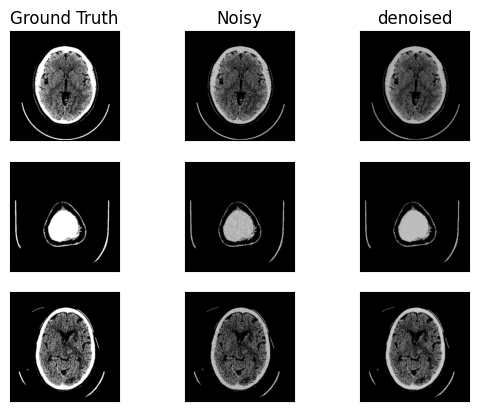

In [27]:
with torch.no_grad():
    predict = model(torch.permute(torch.tensor(X_test[0:10,:,:],  dtype=torch.float32,device=device).unsqueeze(0),(1,0,2,3)))
predict = predict.cpu()
predict = predict.detach().numpy()
predict = np.reshape(predict,(10,256,256))
z = np.max(predict,axis=(1,2))
z.shape = (10,1,1)
predict = np.divide(predict,z)
y_test_show = y_test[0:10,:,:]
X_test_show = X_test[0:10,:,:]
print(predict.shape)
# ---
# item = sample(list(np.random.permutation(X_test_show.shape[0])), 3)
fig, ax = plt.subplots(3,3)
for i in range(0,3):
    ax[i,0].imshow(X_test_show[i+3,:,:],cmap='gray');
    ax[i,0].set_xticks([]);
    ax[i,0].set_yticks([]);
    ax[i,1].imshow(y_test_show[i+3,:,:],cmap='gray');
    ax[i,1].set_xticks([]);
    ax[i,1].set_yticks([]);
    ax[i,2].imshow(predict[i+3,:,:],cmap='gray');
    ax[i,2].set_xticks([]);
    ax[i,2].set_yticks([]);
ax[0,0].set_title('Ground Truth');
ax[0,1].set_title('Noisy');
ax[0,2].set_title('denoised');
# Notes: you don't have to follow this structure as long as you can build the network correctly
print('PSNR before: %s' % peak_signal_noise_ratio(X_test_show,y_test_show))
print('PSNR after: %s' % peak_signal_noise_ratio(X_test_show,predict)) # Note: Show the average PSNR before and after denoising

print(np.max(predict[0,:,:]),np.max(X_test_show[0,:,:]))

In [25]:
import pickle
pickle.dump(model, open('modelVAE_new.pkl', 'wb'))
# model = pickle.load(open('modelVAE.pkl', 'rb'))

In [23]:
class ConvolutionLayer3(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvolutionLayer3, self).__init__()
        # ---
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
        self.relu = nn.ReLU()
        self.droput = nn.Dropout2d(p=0.2)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        # self.conv22 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,kernel_size=(1,1),stride=(1,1),padding=(0,0))
        # self.conv33 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,kernel_size=(1,1),stride=(1,1),padding=(0,0))
        
        
        # ---

    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.conv(x)
        x = self.relu(x)
        x = self.droput(x)
        x = self.batchnorm(x)
        # x = self.conv22(x)
        # x = self.conv33(x)
        return x

class DeconvolutionLayer3(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DeconvolutionLayer3, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding,output_padding=(1,1))
        self.relu = nn.ReLU()
        self.droput = nn.Dropout2d(p=0.2)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.deconv(x)
        x = self.relu(x)
        x = self.droput(x)
        x = self.batchnorm(x)
        return x
        
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        # ---
        # Put your codes here to put together the convolution and deconvolution/transpose convolution layers
        # ---
        self.conv1 = ConvolutionLayer3(in_channels = 1, out_channels = 64, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.conv2 = ConvolutionLayer3(in_channels =64, out_channels = 128, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.conv3 = ConvolutionLayer3(in_channels = 128, out_channels = 256, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        # self.conv4 = ConvolutionLayer3(in_channels = 256, out_channels = 512, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.conv4 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        # self.conv5 = ConvolutionLayer3(in_channels = 256, out_channels = 512, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        self.deconv1 = DeconvolutionLayer3(in_channels = 512, out_channels = 256, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.deconv2 = DeconvolutionLayer3(in_channels = 512, out_channels = 128, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.deconv3 = DeconvolutionLayer3(in_channels = 256, out_channels =64, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.deconv4 = DeconvolutionLayer3(in_channels = 128, out_channels = 1, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.tanh = nn.Tanh()

    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.conv1(x)
        y1 = x.clone().detach() #b
        x = self.conv2(x)
        y2 = x.clone().detach() #b
        x = self.conv3(x)
        y3 = x.clone().detach() #b
        # x = self.conv4(x)
        
        mu =  (self.conv4(x))
        sigma = torch.exp((self.conv5(x)))
        x = mu + sigma*self.N.sample(mu.shape)
        self.kl = torch.mean(-0.5 * torch.sum(1 + torch.log(sigma) - mu ** 2 - sigma, dim = (2,3)), dim = (0,1))
        
        x = self.deconv1(x)
        x = torch.cat([x,y3],1)
        x = self.deconv2(x)
        x = torch.cat([x,y2],1)
        x = self.deconv3(x)
        x = torch.cat([x,y1],1)
        x = self.deconv4(x)
        return x

# Create an instance of the Model
model = Model3();
model.to(device='cuda');

# Print model architecture
from torchsummary import summary
summary(model,(1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,664
              ReLU-2         [-1, 64, 128, 128]               0
         Dropout2d-3         [-1, 64, 128, 128]               0
       BatchNorm2d-4         [-1, 64, 128, 128]             128
 ConvolutionLayer3-5         [-1, 64, 128, 128]               0
            Conv2d-6          [-1, 128, 64, 64]         204,928
              ReLU-7          [-1, 128, 64, 64]               0
         Dropout2d-8          [-1, 128, 64, 64]               0
       BatchNorm2d-9          [-1, 128, 64, 64]             256
ConvolutionLayer3-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
        Dropout2d-13          [-1, 256, 32, 32]               0
      BatchNorm2d-14          [-1, 256,

In [24]:
from torch.optim.lr_scheduler import StepLR
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:10"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
criterion1 = nn.MSELoss()
criterion2 = nn.L1Loss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)
num_epochs =  15
Train_loss = []
Val_loss = []
device = 'cuda'
# Training loop
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
for epoch in range(num_epochs):
    model.train()
    device = 'cuda'
    model.to(device=device)
    train_loss = 0
    for batch_no, (noisy_batch, clean_batch) in enumerate(train_loader):
        # Forward pass
        # ---
        # Put your codes here to compute training loss
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        optimizer.zero_grad()
        noisy_batch, clean_batch = noisy_batch.unsqueeze(0), clean_batch.unsqueeze(0) 
        noisy_batch, clean_batch = torch.permute(noisy_batch,(1,0,2,3)), torch.permute(clean_batch,(1,0,2,3))
        # res = clean_batch - noisy_batch
        # print(noisy_batch.shape)
        noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)
        outputs = model(noisy_batch)
        # o_res = clean_batch - noisy_batch
        loss1 = criterion1(outputs, clean_batch)
        # loss2 = criterion2(outputs, clean_batch)
        loss = loss1+model.kl
        train_loss += loss1.item() + model.kl.item()
        loss.backward()
        optimizer.step()
        
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_no, (noisy_batch, clean_batch) in enumerate(test_loader):
            # Forward pass
            # ---
            # Put your codes here to compute validation loss
            # ---
            # Notes: you don't have to follow this structure as long as you can build the network correctly
            optimizer.zero_grad()
            noisy_batch, clean_batch = noisy_batch.unsqueeze(0), clean_batch.unsqueeze(0) 
            noisy_batch, clean_batch = torch.permute(noisy_batch,(1,0,2,3)), torch.permute(clean_batch,(1,0,2,3))
            noisy_batch, clean_batch = noisy_batch.to(device), clean_batch.to(device)
            # res = clean_batch - noisy_batch
            outputs = model(noisy_batch)
            loss1 = criterion1(outputs, clean_batch)
            # loss2 = criterion2(outputs, clean_batch)
            # loss = loss1+loss2
            # loss = criterion1(outputs, clean_batch)
            # loss2 = criterion2(clean_batch-noisy_batch,clean_batch-outputs)
            
            val_loss += loss1.item()+model.kl
        scheduler.step()
        # Print average loss
            # ---
            # Put your codes here to print the training loss (optional but good for debugging/development purposes)
            # ---
            # Notes: you don't have to follow this structure as long as you can build the network correctly
    Train_loss.append(train_loss/len(train_loader))
    Val_loss.append(val_loss/len(test_loader))
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1:.0f}/{num_epochs:.0f}], Train loss: {train_loss/len(train_loader):.4f}, Val loss: {val_loss/len(test_loader):.4f}, current_lr: {current_lr:.6f}')
    if val_loss/len(test_loader) < 0.001:
        break

Epoch [1/15], Train loss: 7.7897, Val loss: 0.3257, current_lr: 0.000500
Epoch [2/15], Train loss: 1.1361, Val loss: 0.1776, current_lr: 0.000500
Epoch [3/15], Train loss: 0.7922, Val loss: 0.1903, current_lr: 0.000500
Epoch [4/15], Train loss: 1.2240, Val loss: 0.4685, current_lr: 0.000500
Epoch [5/15], Train loss: 1.4905, Val loss: 0.2276, current_lr: 0.000500
Epoch [6/15], Train loss: 0.8741, Val loss: 0.1950, current_lr: 0.000500
Epoch [7/15], Train loss: 0.7696, Val loss: 0.0971, current_lr: 0.000500
Epoch [8/15], Train loss: 0.5658, Val loss: 0.1858, current_lr: 0.000500
Epoch [9/15], Train loss: 0.8404, Val loss: 0.1741, current_lr: 0.000500
Epoch [10/15], Train loss: 0.5950, Val loss: 0.2058, current_lr: 0.000250
Epoch [11/15], Train loss: 0.2087, Val loss: 0.0071, current_lr: 0.000250
Epoch [12/15], Train loss: 0.0943, Val loss: 0.0055, current_lr: 0.000250
Epoch [13/15], Train loss: 0.0815, Val loss: 0.0059, current_lr: 0.000250
Epoch [14/15], Train loss: 0.0795, Val loss: 0.

In [72]:
print(model.kl.item())

0.0002891163749154657


In [47]:
model.N

Normal(loc: 0.0, scale: 1.0)